In [58]:
import pandas as pd
import numpy as np
import warnings
import pycountry
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
pd.set_option('display.max_columns', 100)

Num GPUs Available:  1


### Set params

In [ ]:
data_location = './local/'

In [3]:
txn_table_name = 'transactions.csv'
fx_table_name = 'fx_rates.csv'
user_table_name = 'users.csv'
country_table_name = 'countries.csv'
fx_detail_table_name = 'currency_details.csv'
fraud_table_name = 'fraudsters.csv'

### Load tables

In [4]:
df_txn = pd.read_csv(os.path.join(data_location, txn_table_name))
df_txn.drop(df_txn.columns[0], axis=1, inplace=True)
df_txn.columns = [c.lower() for c in df_txn.columns]
df_txn['merchant_country'] = df_txn['merchant_country'].str[-3:].str.strip()
df_txn['numcode'] = np.where(df_txn['merchant_country'].str.isnumeric(), df_txn['merchant_country'], None)

In [5]:
df_txn.head()

,currency,amount,state,created_date,merchant_category,merchant_country,entry_method,user_id,type,source,id,numcode
0,GBP,3738,COMPLETED,2015-10-11 09:05:43.016000,bar,AUS,misc,7285c1ec-31d0-4022-b311-0ad9227ef7f4,CARD_PAYMENT,GAIA,5a9ee109-e9b3-4598-8dd7-587591e6a470,None
1,GBP,588,COMPLETED,2015-10-11 20:08:39.150000,NaN,CA,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,CARD_PAYMENT,GAIA,28d68bf4-460b-4c8e-9b95-bcda9ab596b5,None
2,GBP,1264,COMPLETED,2015-10-11 11:37:40.908000,NaN,UKR,misc,0fe472c9-cf3e-4e43-90f3-a0cfb6a4f1f0,CARD_PAYMENT,GAIA,1f1e8817-d40b-4c09-b718-cfc4a6f211df,None
3,GBP,66,REVERTED,2015-10-11 20:08:35.310000,NaN,CA,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,CARD_PAYMENT,GAIA,a7aaf78c-d201-456f-9e6d-612a795e8c32,None
4,GBP,968,COMPLETED,2015-10-11 02:46:47.640000,supermarket,NZL,misc,821014c5-af06-40ff-91f4-77fe7667809f,CARD_PAYMENT,GAIA,27dd99a2-5539-4ba9-876a-1a94abc2701f,None


In [6]:
df_country = pd.read_csv(os.path.join(data_location, country_table_name), dtype=str)
df_country['phonecode'] = df_country['phonecode'].apply(lambda x: x.zfill(3) if not isinstance(x, float) else x)

In [7]:
# try to get proper merchant conuntry
code_mapping = {country.alpha_2: country.name for country in pycountry.countries}
code2_mapping = {country.alpha_3: country.name for country in pycountry.countries}
numcode_mapping = {country.numeric: country.name for country in pycountry.countries}
df_txn['merchant_country_map'] = df_txn['merchant_country'].apply(lambda x: code_mapping.get(x, None))
df_txn['merchant_country_map'] = df_txn[['merchant_country', 'merchant_country_map']].apply(lambda x: code2_mapping.get(x[0], x[1]), axis=1)
df_txn['merchant_country_map'] = df_txn[['merchant_country', 'merchant_country_map']].apply(lambda x: numcode_mapping.get(x[0], x[1]), axis=1)
df_txn['name'] = df_txn.merge(df_country[['phonecode', 'name']].dropna(subset=['phonecode']), 
                              left_on=['numcode'], right_on=['phonecode'], how='left')['name']
df_txn['merchant_country_map'] = np.where(df_txn['merchant_country_map'].isnull(),
                                     df_txn['name'],
                                     df_txn['merchant_country_map'])
df_txn.drop(columns=['name', 'merchant_country', 'numcode'], inplace=True)
df_txn['merchant_country_map'] = df_txn['merchant_country_map'].fillna('unfound')

In [8]:
df_fx = pd.read_csv(os.path.join(data_location, fx_table_name))
df_fx = df_fx[df_fx['base_ccy'] == 'USD']
df_fx = pd.concat([df_fx, pd.DataFrame([['USD', 'USD', 1.]], columns=['base_ccy', 'ccy', 'rate'])], ignore_index=True)

In [9]:
df_fx_detail = pd.read_csv(os.path.join(data_location, fx_detail_table_name))

In [10]:
df_user = pd.read_csv(os.path.join(data_location, user_table_name))
df_user.drop(df_user.columns[0], axis=1, inplace=True)
df_user.columns = [c.lower() for c in df_user.columns]
df_user.rename(columns={'id':'user_id'}, inplace=True)

In [11]:
df_fraud = pd.read_csv(os.path.join(data_location, fraud_table_name))
df_fraud.drop(df_fraud.columns[0], axis=1, inplace=True)
df_fraud['fraud'] = 'Y'

### Merge table and cleansing

In [12]:
# flag fraud user
df_user = df_user.merge(df_fraud, on=['user_id'], how='left')
df_user['fraud'] = np.where(df_user['fraud'] == 'Y', 'Y', 'N')

In [13]:
# join fx and fx detail
df_fx = df_fx.merge(df_fx_detail[['currency', 'exponent', 'is_crypto']], left_on=['ccy'], right_on=['currency'], how='left')
df_fx.drop(columns=['currency', 'base_ccy'], inplace=True)

In [14]:
# align amount into usd
df_txn = df_txn.merge(df_fx, left_on=['currency'], right_on=['ccy'], how='left')
df_txn['amount_usd'] = df_txn['amount'] * df_txn['rate']
df_txn.drop(columns=['amount'], inplace=True)

In [15]:
# merge into one table
df_txn = df_txn.merge(df_user, on=['user_id'], how='left', suffixes=['_txn', '_user'])

In [16]:
df_txn.head()

,currency,state_txn,created_date_txn,merchant_category,entry_method,user_id,type,source,id,merchant_country_map,ccy,rate,exponent,is_crypto,amount_usd,failed_sign_in_attempts,kyc,birth_year,country,state_user,created_date_user,terms_version,phone_country,has_email,fraud
0,GBP,COMPLETED,2015-10-11 09:05:43.016000,bar,misc,7285c1ec-31d0-4022-b311-0ad9227ef7f4,CARD_PAYMENT,GAIA,5a9ee109-e9b3-4598-8dd7-587591e6a470,Australia,GBP,1.319906,2.0,False,4933.809028,0,PASSED,1963,GB,ACTIVE,2015-08-25 19:24:41.936000,2018-09-20,GB||JE||IM||GG,1,N
1,GBP,COMPLETED,2015-10-11 20:08:39.150000,NaN,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,CARD_PAYMENT,GAIA,28d68bf4-460b-4c8e-9b95-bcda9ab596b5,Canada,GBP,1.319906,2.0,False,776.104791,0,PASSED,1988,GB,ACTIVE,2015-09-25 21:38:40.670000,2018-05-25,GB||JE||IM||GG,1,N
2,GBP,COMPLETED,2015-10-11 11:37:40.908000,NaN,misc,0fe472c9-cf3e-4e43-90f3-a0cfb6a4f1f0,CARD_PAYMENT,GAIA,1f1e8817-d40b-4c09-b718-cfc4a6f211df,Ukraine,GBP,1.319906,2.0,False,1668.361319,0,PASSED,1977,GB,ACTIVE,2015-09-05 17:51:04.339000,2018-09-20,GB||JE||IM||GG,1,N
3,GBP,REVERTED,2015-10-11 20:08:35.310000,NaN,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,CARD_PAYMENT,GAIA,a7aaf78c-d201-456f-9e6d-612a795e8c32,Canada,GBP,1.319906,2.0,False,87.113803,0,PASSED,1988,GB,ACTIVE,2015-09-25 21:38:40.670000,2018-05-25,GB||JE||IM||GG,1,N
4,GBP,COMPLETED,2015-10-11 02:46:47.640000,supermarket,misc,821014c5-af06-40ff-91f4-77fe7667809f,CARD_PAYMENT,GAIA,27dd99a2-5539-4ba9-876a-1a94abc2701f,New Zealand,GBP,1.319906,2.0,False,1277.669112,0,FAILED,1992,GB,ACTIVE,2015-08-03 08:30:36.503000,NaN,GB||JE||IM||GG,1,N


### Data model - Cleansing

In [17]:
# remove unnecessary columns
df_txn.drop(columns=['state_user', 'id', 'user_id', 'currency', 'rate'], inplace=True)

In [18]:
# fillna
df_txn = df_txn.fillna('unknown')

In [19]:
# create features
for col in ['created_date_txn', 'created_date_user']:
    df_txn[col] = pd.to_datetime(df_txn[col]) # convert to datetime
    
df_txn['txn_created_year'] = df_txn['created_date_txn'].dt.year
df_txn['txn_created_month'] = df_txn['created_date_txn'].dt.month
df_txn['txn_created_day'] = df_txn['created_date_txn'].dt.day
df_txn['txn_created_weekday'] = df_txn['created_date_txn'].dt.weekday

df_txn['user_created_year'] = df_txn['created_date_user'].dt.year
df_txn['user_created_month'] = df_txn['created_date_user'].dt.month
df_txn['user_created_day'] = df_txn['created_date_user'].dt.day
df_txn['user_created_weekday'] = df_txn['created_date_user'].dt.weekday

df_txn.drop(columns=['created_date_txn', 'created_date_user'], inplace=True)

In [20]:
# change to lower cases:
for col in df_txn.select_dtypes(include='object'):
    df_txn[col] = df_txn[col].str.lower()

In [21]:
df_txn.head()

,state_txn,merchant_category,entry_method,type,source,merchant_country_map,ccy,exponent,is_crypto,amount_usd,failed_sign_in_attempts,kyc,birth_year,country,terms_version,phone_country,has_email,fraud,txn_created_year,txn_created_month,txn_created_day,txn_created_weekday,user_created_year,user_created_month,user_created_day,user_created_weekday
0,completed,bar,misc,card_payment,gaia,australia,gbp,2.0,False,4933.809028,0,passed,1963,gb,2018-09-20,gb||je||im||gg,1,n,2015,10,11,6,2015,8,25,1
1,completed,unknown,misc,card_payment,gaia,canada,gbp,2.0,False,776.104791,0,passed,1988,gb,2018-05-25,gb||je||im||gg,1,n,2015,10,11,6,2015,9,25,4
2,completed,unknown,misc,card_payment,gaia,ukraine,gbp,2.0,False,1668.361319,0,passed,1977,gb,2018-09-20,gb||je||im||gg,1,n,2015,10,11,6,2015,9,5,5
3,reverted,unknown,misc,card_payment,gaia,canada,gbp,2.0,False,87.113803,0,passed,1988,gb,2018-05-25,gb||je||im||gg,1,n,2015,10,11,6,2015,9,25,4
4,completed,supermarket,misc,card_payment,gaia,new zealand,gbp,2.0,False,1277.669112,0,failed,1992,gb,unknown,gb||je||im||gg,1,n,2015,10,11,6,2015,8,3,0


### Data model - Preparation

In [22]:
from sklearn.preprocessing import LabelEncoder

In [23]:
col_label = ['is_crypto', 'fraud']
col_onehot = df_txn.select_dtypes(include='object').columns.tolist()
col_onehot = [c for c in col_onehot if c not in col_label]

In [24]:
# Label encoding
label = LabelEncoder()
df_txn[col_label] = df_txn[col_label].apply(label.fit_transform)

In [25]:
# One hot encoding
for col in col_onehot:
    df_txn = pd.concat([pd.get_dummies(df_txn[col], 
                                       prefix=col), 
                        df_txn.drop(columns=[col])],
                      axis=1)

### Data model - upsampling

In [26]:
from sklearn.utils import resample

In [27]:
df_txn['fraud'].value_counts()

0    674108
1     14543
Name: fraud, dtype: int64

In [28]:
fraud_txn = df_txn[df_txn['fraud'] == 1]
normal_txn = df_txn[~(df_txn['fraud'] == 1)]

In [29]:
fraud_upsample = resample(fraud_txn,
                         replace=True,
                         n_samples=len(normal_txn),
                         random_state=0)

In [30]:
df = pd.concat([normal_txn, fraud_upsample], ignore_index=True)
df.shape

(1348216, 520)

### Data model - modeling

In [57]:
from xgboost import XGBClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [32]:
y_col = ['fraud']
x_col = df.columns.tolist()
x_col = [c for c in x_col if c not in y_col]

In [33]:
x_train, x_test, y_train, y_test = train_test_split(
                                            df[x_col], 
                                            df[y_col],
                                            train_size=.8,
                                            random_state=0)

In [38]:
x_train.shape, x_test.shape

((1078572, 519), (269644, 519))

In [40]:
y_train.value_counts()

fraud
0        539467
1        539105
dtype: int64

In [42]:
y_test.value_counts()

fraud
1        135003
0        134641
dtype: int64

In [34]:
xgb = XGBClassifier()
model = xgb.fit(x_train, y_train)

[20:44:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [35]:
y_pred = model.predict(x_test)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    134641
           1       0.99      1.00      1.00    135003

    accuracy                           1.00    269644
   macro avg       1.00      1.00      1.00    269644
weighted avg       1.00      1.00      1.00    269644



In [52]:
feature_importance = model.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

df_feature = pd.DataFrame(data=values, index=keys, columns=['score']).sort_values(by='score', ascending=False)

<AxesSubplot:>

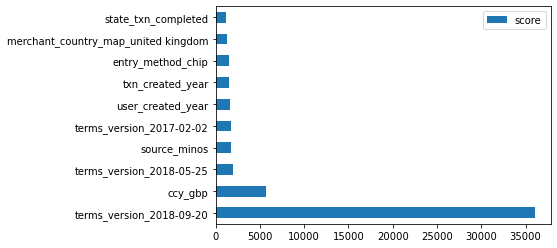

In [51]:
df_feature.nlargest(10, columns='score').plot(kind='barh')

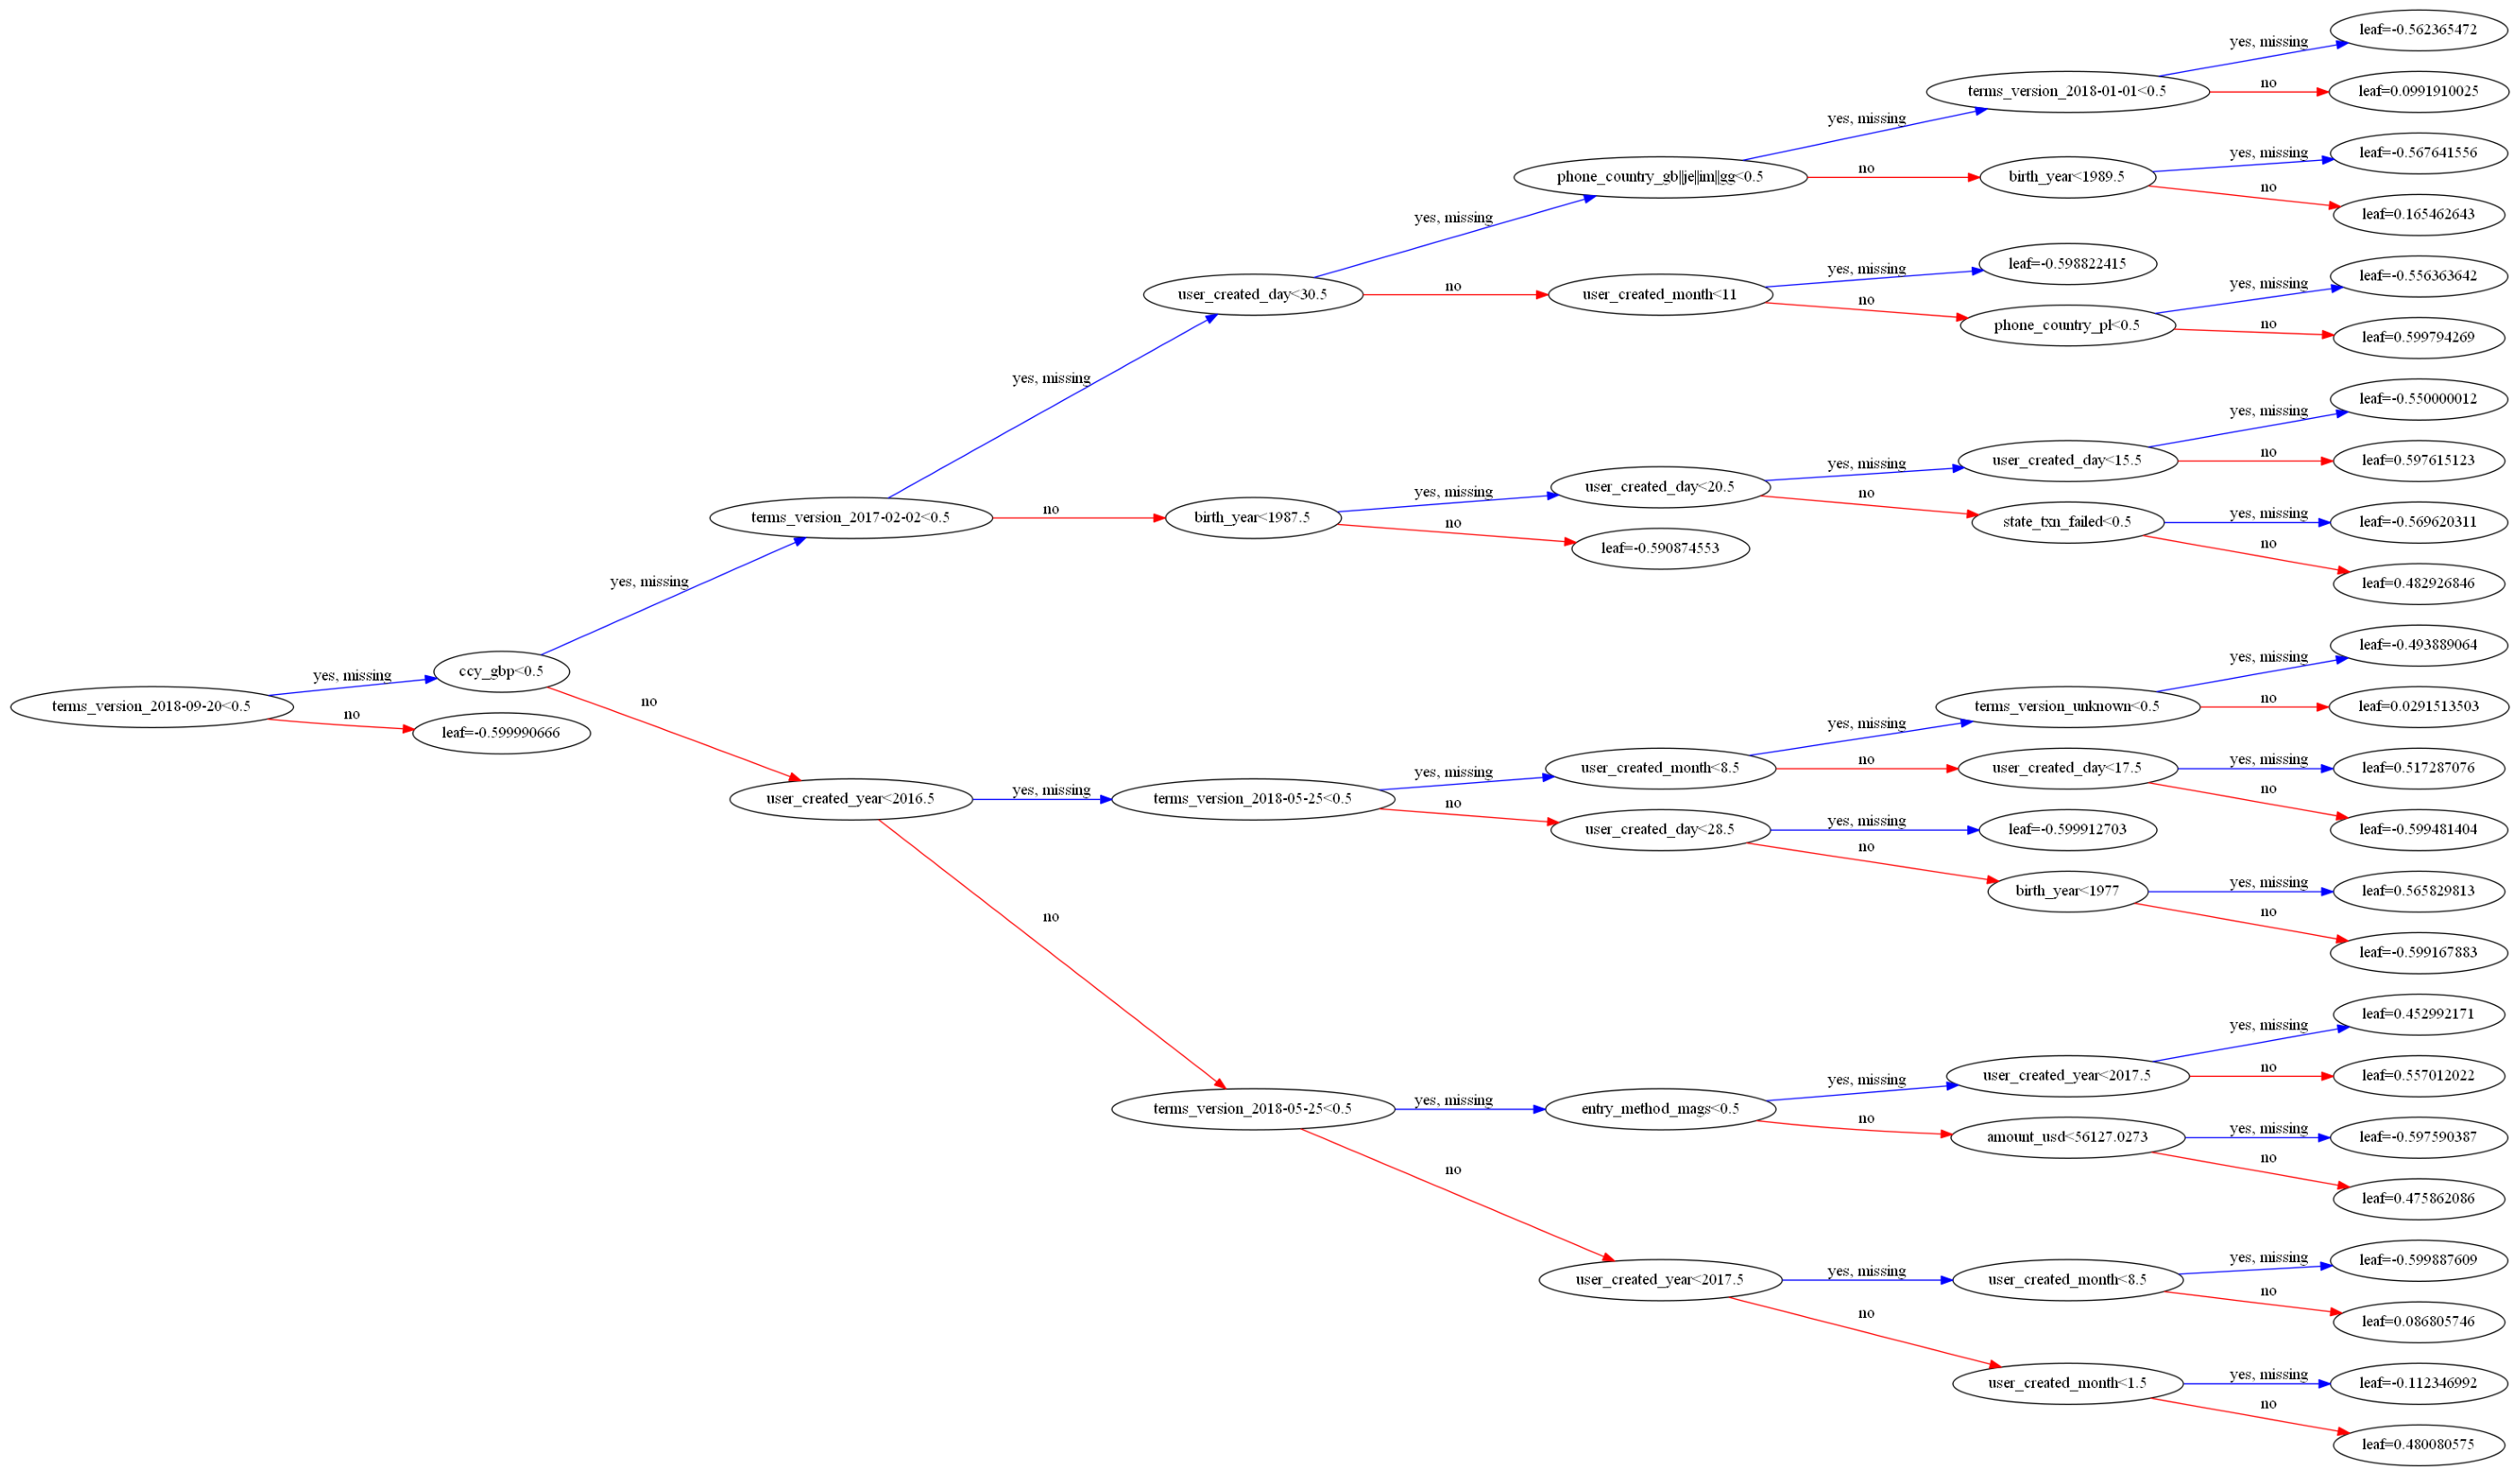

In [66]:
fig, ax = plt.subplots(figsize=(50, 50))
plot_tree(model, rankdir='LR', ax=ax)
plt.savefig('tree.png')
plt.show()